In [80]:
import random
import simpy
import matplotlib.pyplot as plt
import numpy as np

In [81]:
SEED = 9999
random.seed(SEED)

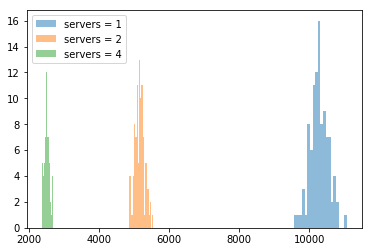

[10280.933184802863, 5163.766663016872, 2511.0152036969434]


In [115]:
class Source(object):
    ''' Generate the customers comming into the system with some exponetially distributed interval time.
    '''
    def __init__(self, env, numCustomers, interval, serveTime, server):
        self.env = env
        self.numCustomers = numCustomers
        self.interval = interval
        self.serveTime = serveTime
        self.server = server
        self.action = env.process(self.run())
    
    def run(self):
        ''' Create n customers and timeout after each creation
        '''
        for i in range(1, self.numCustomers+1):
            customer = Customer(self.env, i, self.server, self.serveTime)
            timeUntillNext = random.expovariate(1. / self.interval)
            yield self.env.timeout(timeUntillNext)

class Customer(object):
    ''' Customers request the passed resource if they can make use of an open service.
        They are then served which takes some exponentially distributed time.
    '''
    def __init__(self, env, number, server, serveTime):
        self.env = env
        self.number = number
        self.server = server
        self.serveTime = serveTime
        self.action = env.process(self.run())
    
    def run(self):
        ''' Create a service request and use it once it becomes available
        '''
        arrival = self.env.now
#         print('customer %d starts at %d' % (self.number, self.env.now))
        with self.server.request() as req:
            yield req
            results.append(self.env.now-arrival)
#             print('customer %d served at %d' % (self.number, self.env.now))
            yield self.env.timeout(random.expovariate(1./self.serveTime))
#             print('customer %d done at %d' % (self.number, self.env.now))

customers = 1000
capacity = [1,2,4]
reps = 100
rho = 0.9
serviceTime = 10.0
arrival = 9.9
means = []
plt.figure()
for cap in capacity:
    totalResults = []
    arrival /= cap
    for _ in range(reps):
        results = []
        env = simpy.Environment()
        server = simpy.Resource(env, capacity=cap)
        source = Source(env, customers, arrival, serviceTime, server)
        env.run()
        totalResults.append(env.now)
    means.append(np.mean(totalResults))
    plt.hist(totalResults, bins=20, alpha=0.5, label="servers = " + str(cap))
#     plt.plot([means[-1], means[-1]], [0, 50], scaley=False, linestyle="--", label="mean n=" + str(cap))
plt.legend()
plt.show()
print(means)

9.0 10.0 1
4.5 10.0 2
2.25 10.0 4


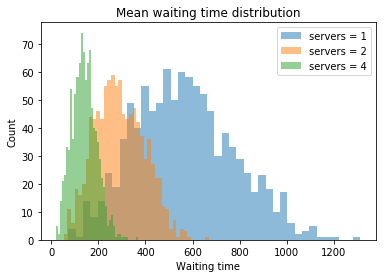

[563.9770081814198, 290.05495788042106, 140.0115132926966]


In [151]:
customers = 1000
capacity = [1,2,4]
reps = 1000
serviceTime = 10.0
arrival = 9.
means = []
plt.figure()
for cap in capacity:
    totalResults = []
    newArrival = arrival/cap
    print(newArrival, serviceTime, cap)
    for _ in range(reps):
        results = []
        env = simpy.Environment()
        server = simpy.Resource(env, capacity=cap)
        source = Source(env, customers, newArrival, serviceTime, server)
        env.run()
        totalResults.append(np.mean(results))
    means.append(np.mean(totalResults))
    plt.hist(totalResults, bins=40, alpha=0.5, label="servers = " + str(cap))
#     plt.plot([means[-1], means[-1]], [0, 50], scaley=False, linestyle="--", label="mean n=" + str(cap))
plt.legend()
plt.title("Mean waiting time distribution")
plt.xlabel("Waiting time")
plt.ylabel("Count")
plt.show()
print(means)

In [157]:
customers = 1000
reps = 100
rho = np.linspace(0.1, 0.95, 18)
serviceTime = 10
means = []
perc25 = []
perc75 = []
for r in rho:
    totalResults = []
    newArrival = 100.0/(r*serviceTime)
    print(newArrival, serviceTime)
    for _ in range(reps):
        results = []
        env = simpy.Environment()
        server = simpy.Resource(env, capacity=1)
        source = Source(env, customers, newArrival, serviceTime, server)
        env.run()
        totalResults.append(np.mean(results))
    means.append(np.mean(totalResults))
    perc25.append(np.percentile(totalResults, 25))
    perc75.append(np.percentile(totalResults, 75))

plt.figure()
plt.scatter(rho, means)
plt.scatter(rho, perc25)
plt.scatter(rho, perc75)
plt.show()

1.0 10
0.6666666666666666 10
0.5 10
0.4 10
0.3333333333333333 10
0.2857142857142857 10
0.25 10
0.2222222222222222 10
0.2 10
0.18181818181818185 10
0.16666666666666666 10


KeyboardInterrupt: 

# Shortest job first

10.0 9.0 1
5.0 9.0 2
2.5 9.0 4


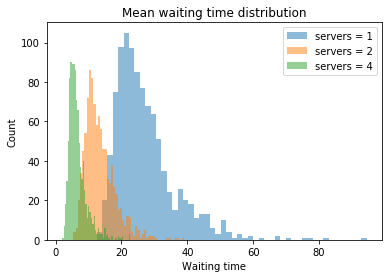

[27.20816267682388, 13.444286010415958, 6.642360741844613]


In [152]:
class sjf_Source(object):
    ''' Generate the customers comming into the system with some exponetially distributed interval time.
    '''
    def __init__(self, env, numCustomers, interval, serveTime, server):
        self.env = env
        self.numCustomers = numCustomers
        self.interval = interval
        self.serveTime = serveTime
        self.server = server
        self.action = env.process(self.run())
    
    def run(self):
        ''' Create n customers and timeout after each creation
        '''
        for i in range(1, self.numCustomers+1):
            customer = sjf_Customer(self.env, i, self.server, self.serveTime)
            timeUntillNext = random.expovariate(1. / self.interval)
            yield self.env.timeout(timeUntillNext)

class sjf_Customer(object):
    ''' Customers request the passed resource if they can make use of an open service.
        They are then served which takes some exponentially distributed time.
    '''
    def __init__(self, env, number, server, serveTime):
        self.env = env
        self.number = number
        self.server = server
        self.serveTime = random.expovariate(1./serveTime)
        self.action = env.process(self.run())
    
    def run(self):
        ''' Create a service request and use it once it becomes available
        '''
        arrival = self.env.now
        with self.server.request(priority=self.serveTime) as req:
            yield req
            results.append(self.env.now-arrival)
            yield self.env.timeout(self.serveTime)
#             print('customer %d done at %d' % (self.number, self.env.now))

customers = 1000
capacity = [1,2,4]
reps = 1000
rho = 0.
serviceTime = 9.0
arrival = 10.
means = []
plt.figure()
for cap in capacity:
    totalResults = []
    newArrival = arrival/cap
    print(newArrival, serviceTime, cap)
    for _ in range(reps):
        results = []
        env = simpy.Environment()
        server = simpy.PriorityResource(env, capacity=cap)
        source = sjf_Source(env, customers, newArrival, serviceTime, server)
        env.run()
        totalResults.append(np.mean(results))
    means.append(np.mean(totalResults))
    plt.hist(totalResults, bins=50, alpha=0.5, label="servers = " + str(cap))
#     plt.plot([means[-1], means[-1]], [0, 50], scaley=False, linestyle="--", label="mean n=" + str(cap))
plt.legend()
plt.title("Mean waiting time distribution")
plt.xlabel("Waiting time")
plt.ylabel("Count")
plt.show()
print(means)

# M/D/n

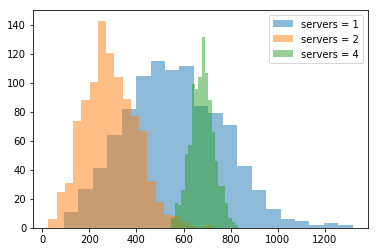

[561.5254572232357, 288.894176283442, 679.1314347850375]


In [182]:
class md_Source(object):
    ''' Generate the customers comming into the system with some exponetially distributed interval time.
    '''
    def __init__(self, env, numCustomers, interval, serveTime, server):
        self.env = env
        self.numCustomers = numCustomers
        self.interval = interval
        self.serveTime = serveTime
        self.server = server
        self.action = env.process(self.run())
    
    def run(self):
        ''' Create n customers and timeout after each creation
        '''
        for i in range(1, self.numCustomers+1):
            customer = Customer(self.env, i, self.server, self.serveTime)
            timeUntillNext = random.expovariate(1. / self.interval)
            yield self.env.timeout(timeUntillNext)

class md_Customer(object):
    ''' Customers request the passed resource if they can make use of an open service.
        They are then served which takes some exponentially distributed time.
    '''
    def __init__(self, env, number, server, serveTime):
        self.env = env
        self.number = number
        self.server = server
        self.serveTime = serveTime
        self.action = env.process(self.run())
    
    def run(self):
        ''' Create a service request and use it once it becomes available
        '''
        arrival = self.env.now
#         print('customer %d starts at %d' % (self.number, self.env.now))
        with self.server.request() as req:
            yield req
            results.append(self.env.now-arrival)
#             print('customer %d served at %d' % (self.number, self.env.now))
            yield self.env.timeout(self.serveTime)
#             print('customer %d done at %d' % (self.number, self.env.now))

customers = 1000
capacity = [1,2,4]
reps = 1000
rho = 0.9
serviceTime = 10.0
arrival = 9.0
means = []
plt.figure()
for cap in capacity:
    totalResults = []
    arrival /= cap
    for _ in range(reps):
        results = []
        env = simpy.Environment()
        server = simpy.Resource(env, capacity=cap)
        source = Source(env, customers, arrival, serviceTime, server)
        env.run()
        totalResults.append(np.mean(results))
    means.append(np.mean(totalResults))
    plt.hist(totalResults, bins=20, alpha=0.5, label="servers = " + str(cap))
#     plt.plot([means[-1], means[-1]], [0, 50], scaley=False, linestyle="--", label="mean n=" + str(cap))
plt.legend()
plt.show()
print(means)

9.942164690226935


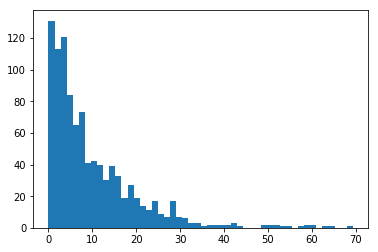

In [181]:
y = [random.expovariate(1. / 10.0) for _ in range(1000)]
print(np.mean(y))
plt.figure()
plt.hist(y, bins=50)
plt.show()